# Online learning for time series prediction

We implement the online learning filter developped in [1] and reproduce
the "setting 1" in the paper.


We use the following modules from WAX-ML:
- ARMA : to generate a modeled time-series
- SNARIMAX : to adaptively learn to predict the generated time-series.
- GymFeedback: To setup a training loop.
- VMap: to add batch dimensions to the training loop
- optim.newton: a newton algorithm as used in [1] and developped in [2]. It extends optax optimizers.

[1] [Anava, O., Hazan, E., Mannor, S. and Shamir, O., 2013, June. Online learning for time series prediction. In Conference on learning theory (pp. 172-184)](https://arxiv.org/pdf/1302.6927.pdf)

[2] [Hazan, E., Agarwal, A. and Kale, S., 2007. Logarithmic regret algorithms for
online convex optimization. Machine Learning, 69(2-3), pp.169-192](https://link.springer.com/content/pdf/10.1007/s10994-007-5016-8.pdf)

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from typing import Any, NamedTuple

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as onp
import optax
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from wax.modules import (
    Buffer,
    FillNanInf,
    GymFeedback,
    Lag,
    OnlineOptimizer,
    SetParams,
    VMap,
)
from wax.optim import newton
from wax.unroll import unroll_transform_with_state


# ARMA

In [3]:
# %load ../../wax/modules/arma.py


class ARMA(hk.Module):
    def __init__(self, alpha, beta, name=None):
        super().__init__(name=name)
        self.alpha = alpha
        self.beta = beta

    def __call__(self, eps):
        eps_buffer = Buffer(len(self.beta) + 1, 0.0, name="eps_buffer")(eps)[:-1]

        y_buffer = hk.get_state(
            "y_buffer",
            eps.shape,
            eps.dtype,
            init=lambda shape, dtype: jnp.zeros(
                ((len(self.alpha),) + shape), dtype=dtype
            ),
        )

        y = self.alpha @ y_buffer + self.beta @ eps_buffer + eps

        y = FillNanInf()(y)

        # reshape with shape of eps (for scalar case)
        y = y.reshape(eps.shape)

        y_buffer = Buffer(len(self.alpha), 0, name="y_buffer")(y)

        hk.set_state("y_buffer", y_buffer)
        return y

Let's generate a sample of the "setting 1" of [1]:

In [4]:
alpha = jnp.array([0.6, -0.5, 0.4, -0.4, 0.3])
beta = jnp.array([0.3, -0.2])

rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
sim = unroll_transform_with_state(lambda eps: ARMA(alpha, beta)(eps))
params, state = sim.init(rng, eps)
y, state = sim.apply(params, state, rng, eps)
y.shape

(1000,)

# SNARIMAX

Let's setup an online model to try to learn the dynamic of the time-series.

In [5]:
# %load ../../wax/modules/snarimax.py
class SNARIMAX(hk.Module):
    """SNARIMAX Adaptive filter.

    It can be used to forecast timeseries with a ARMA dynamic using online learning as described in [^1].

    The API of this module is similar to the one of SNARIMAX model in the river Python library.

    References
    ----------
    [^1] [Anava, O., Hazan, E., Mannor, S. and Shamir, O., 2013, June.
    Online learning for time series prediction. In Conference on learning theory (pp. 172-184)]
    (https://arxiv.org/pdf/1302.6927.pdf)

    """

    def __init__(
        self,
        p: int,  # AR
        d: int,  # differenciate
        q: int,  # MA
        m: int = 1,  # Seasonal part
        sp: int = 0,  # Seasonal AR
        sd: int = 0,
        sq: int = 0,  # Seasonal MA
        model=None,
        name=None,
    ):
        super().__init__(name=name)
        self.p = p
        self.d = d
        self.q = q
        self.m = m
        self.sp = sp
        self.sd = sd
        self.sq = sq
        self.model = model if model is not None else hk.Linear(1, with_bias=False)

    def __call__(self, y, X=None):
        yp = Buffer(self.p + 1, name="y_trues")(y)[1:]

        errp = hk.get_state(
            "errp",
            [],
            init=lambda *_: jnp.full((self.q + 1,) + y.shape, 0.0, y.dtype)[1:],
        )

        X = [X] if X is not None else []
        X += [errp.flatten(), yp.flatten()]
        X = jnp.concatenate(X)
        X = FillNanInf()(X)

        y_pred = self.model(X).reshape(y.shape)
        err = y - y_pred
        errp = Buffer(self.q + 1, name="err_lag")(err)[1:]
        hk.set_state("errp", errp)
        return y_pred, {}

First let's run the filter with it's initial random weights.

<AxesSubplot:>

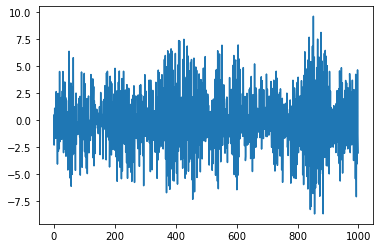

In [6]:
def predict(y, X=None):
    return SNARIMAX(10, 0, 0)(y, X)


sim = unroll_transform_with_state(predict)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10,))
params, state = sim.init(rng, y)
(y_pred, _), state = sim.apply(params, state, rng, y)

pd.Series((y - y_pred)).plot()

In [7]:
def evaluate(y_pred, y):
    return jnp.linalg.norm(y_pred - y) ** 2, {}


def lag(shift=1):
    def __call__(y, X=None):
        yp = Lag(shift)(y)
        Xp = Lag(shift)(X) if X is not None else None
        return yp, Xp

    return __call__


def predict_and_evaluate(y, X=None):
    # predict with lagged data
    y_pred, pred_info = predict(*lag(1)(y, X))

    # evaluate loss with actual data
    loss, loss_info = evaluate(y_pred, y)

    return loss, dict(pred_info=pred_info, loss_info=loss_info)

<AxesSubplot:>

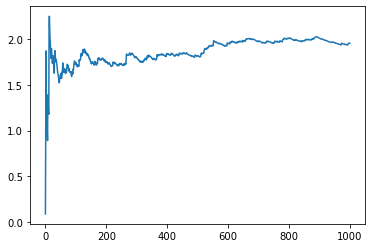

In [8]:
sim = unroll_transform_with_state(predict_and_evaluate)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
params, state = sim.init(rng, y)
(loss, _), state = sim.apply(params, state, rng, y)

pd.Series(loss).expanding().mean().plot()

Since the model is not trained and the coefficient of the SNARIMAX filter a choosen randomly, the loss may diverge

In [9]:
params

FlatMapping({
  'snarimax/~/linear': FlatMapping({
                         'w': DeviceArray([[-0.47023755],
                                           [ 0.07070494],
                                           [-0.07388116],
                                           [ 0.13453043],
                                           [ 0.07728617],
                                           [ 0.0851969 ],
                                           [-0.03324771],
                                           [ 0.17115903],
                                           [ 0.1023274 ],
                                           [-0.4804019 ]], dtype=float32),
                       }),
})

# Learn

## Setup projection

In [11]:
def project_params(params):
    w = params["snarimax/~/linear"]["w"]
    w = jnp.clip(w, -1, 1)
    params["snarimax/~/linear"]["w"] = w
    return params


project_params(hk.data_structures.to_mutable_dict(params))

{'snarimax/~/linear': {'w': DeviceArray([[-0.47023755],
               [ 0.07070494],
               [-0.07388116],
               [ 0.13453043],
               [ 0.07728617],
               [ 0.0851969 ],
               [-0.03324771],
               [ 0.17115903],
               [ 0.1023274 ],
               [-0.4804019 ]], dtype=float32)}}

In [12]:
def learn(y, X=None):
    optim_res = OnlineOptimizer(
        predict_and_evaluate, optax.sgd(1.0e-2), project_params=project_params
    )(y, X)
    return optim_res

<AxesSubplot:>

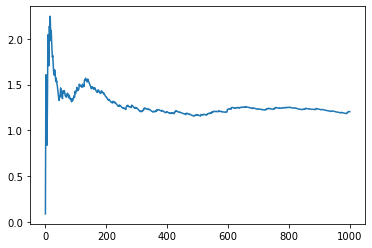

In [13]:
sim = unroll_transform_with_state(learn)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
params, state = sim.init(rng, eps)
optim_res, state = sim.apply(params, state, rng, eps)

pd.Series(optim_res.loss).expanding().mean().plot()

Let's look at the latest weights:

In [14]:
jax.tree_map(lambda x: x[-1], optim_res.updated_params)

FlatMapping({
  'snarimax/~/linear': FlatMapping({
                         'w': DeviceArray([[-0.05703948],
                                           [ 0.12954038],
                                           [-0.13370596],
                                           [-0.00631512],
                                           [-0.02028083],
                                           [ 0.02338953],
                                           [-0.08483381],
                                           [-0.03501338],
                                           [ 0.01006449],
                                           [ 0.00462533]], dtype=float32),
                       }),
})

# Learn and Forecast

In [15]:
class ForecastInfo(NamedTuple):
    optim: Any
    forecast: Any

In [16]:
def learn_and_forecast(y, X=None):
    optim_res = OnlineOptimizer(
        predict_and_evaluate, optax.sgd(1.0e-3), project_params=project_params
    )(*lag(1)(y, X))

    predict_params = optim_res.updated_params

    forecast, forecast_info = SetParams(predict)(predict_params, y, X)
    return forecast, ForecastInfo(optim_res, forecast_info)

<AxesSubplot:>

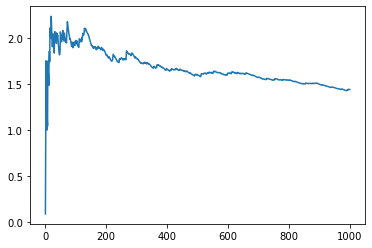

In [17]:
sim = unroll_transform_with_state(learn_and_forecast)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (1000,))
params, state = sim.init(rng, y)
(forecast, info), state = sim.apply(params, state, rng, y)

pd.Series(info.optim.loss).expanding().mean().plot()

# Simulation Environment

# Gym simulation

## GymFeedback

In [18]:
class Env(hk.Module):
    def __call__(self, y_pred, eps):
        alpha = jnp.array([0.6, -0.5, 0.4, -0.4, 0.3])
        beta = jnp.array([0.3, -0.2])

        y = ARMA(alpha, beta)(eps)

        # prediction used on a fresh y observation.
        rw = -((y - y_pred) ** 2)
        return rw, y, {"y": y, "y_pred": y_pred}

In [19]:
def parametrized_learn_and_forecast(opt):
    def learn_and_forecast(y, X=None):
        optim_res = OnlineOptimizer(
            predict_and_evaluate, opt, project_params=project_params
        )(*lag(1)(y, X))

        predict_params = optim_res.updated_params

        forecast, forecast_info = SetParams(predict)(predict_params, y, X)
        return forecast, ForecastInfo(optim_res, forecast_info)

    return learn_and_forecast


class Agent(hk.Module):
    def __init__(self, opt=None, name=None):
        super().__init__(name=name)
        self.opt = opt if opt is not None else optax.sgd(1.0e-3)

    def __call__(self, y):
        y_pred, info = parametrized_learn_and_forecast(self.opt)(y)
        return y_pred, info

In [20]:
def gym_loop(eps):
    return GymFeedback(
        Agent(),
        Env(),
        return_obs=True,
        return_action=True,
        init_action=jnp.array(0.0),
    )(eps)

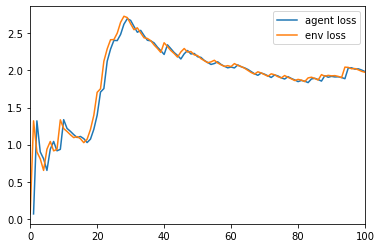

In [21]:
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10000,))
sim = unroll_transform_with_state(gym_loop)
params, state = sim.init(rng, eps)
(gym, info), state = sim.apply(params, state, rng, eps)
pd.Series(info.agent.optim.loss).expanding().mean().plot(label="agent loss")
pd.Series(-gym.reward).expanding().mean().plot(xlim=(0, 100), label="env loss")
plt.legend()

<AxesSubplot:>

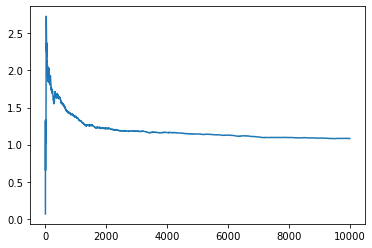

In [22]:
pd.Series(-gym.reward).expanding().mean().plot()  # ylim=(0.09, 0.15))

We see that the agent suffers the same loss as the environment but with a time lag.

## Average over 20 experiments

## Slow version

First, let's do it "naively" by doing a simple python "for loop".

In [23]:
%%time
rng = jax.random.PRNGKey(42)
sim = unroll_transform_with_state(gym_loop)

res = {}
for i in tqdm(onp.arange(20)):
    rng, _ = jax.random.split(rng)
    eps = jax.random.normal(rng, (10000,)) * 0.3
    params, state = sim.init(rng, eps)
    (gym_output, gym_info), final_state = sim.apply(params, state, rng, eps)
    res[i] = gym_info

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 11.1 s, sys: 146 ms, total: 11.2 s
Wall time: 11.2 s


<AxesSubplot:>

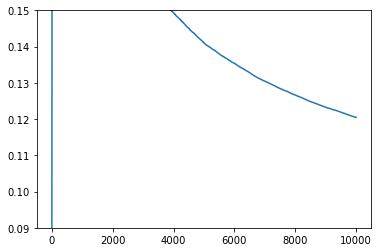

In [24]:
pd.DataFrame({k: pd.Series(v.agent.optim.loss) for k, v in res.items()}).mean(
    1
).expanding().mean().plot(ylim=(0.09, 0.15))

## Fast version with vmap

Instead of using a "for loop" we can use jax's vmap transformation function!

In [25]:
%%time
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (20, 10000)) * 0.3

rng = jax.random.PRNGKey(42)
rng = jax.random.split(rng, num=20)
sim = unroll_transform_with_state(gym_loop)
params, state = jax.vmap(sim.init)(rng, eps)
(gym_output, gym_info), final_state = jax.vmap(sim.apply)(params, state, rng, eps)

CPU times: user 2.1 s, sys: 98.5 ms, total: 2.2 s
Wall time: 1.93 s


This is much faster!

<AxesSubplot:>

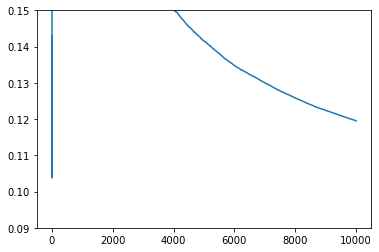

In [26]:
pd.DataFrame(gym_info.agent.optim.loss).mean().expanding().mean().plot(
    ylim=(0.09, 0.15)
)

<AxesSubplot:>

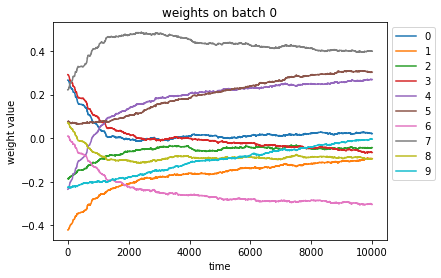

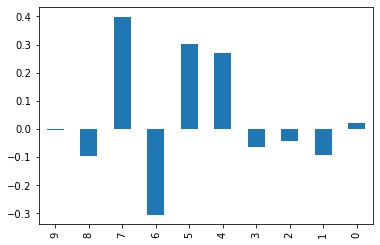

In [27]:
i_batch = 0
w = gym_info.agent.optim.updated_params["snarimax/~/linear"]["w"][i_batch, :, :, 0]
w = pd.DataFrame(w)

ax = w.plot(title=f"weights on batch {i_batch}")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight value")


plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

<AxesSubplot:>

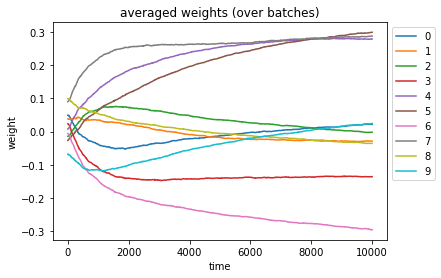

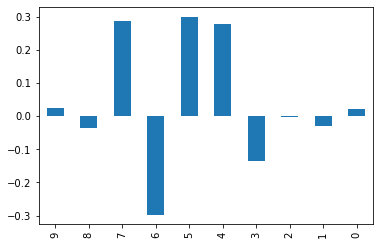

In [28]:
w = gym_info.agent.optim.updated_params["snarimax/~/linear"]["w"].mean(axis=0)[:, :, 0]
w = pd.DataFrame(w)
ax = w.plot(title="averaged weights (over batches)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight")

plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

## With VMap module

We can use the wrapper module `VMap` of WAX-ML. It permits to have an ever simpler syntax.

> Note: we have to swap in position of time and batch dimension in the generation of eps.

In [29]:
%%time
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10000, 20)) * 0.3


def batched_gym_loop(eps):
    return VMap(gym_loop)(eps)


sim = unroll_transform_with_state(batched_gym_loop)

rng = jax.random.PRNGKey(43)
params, state = sim.init(rng, eps)
(gym_output, gym_info), final_state = sim.apply(params, state, rng, eps)

CPU times: user 1.66 s, sys: 33.4 ms, total: 1.69 s
Wall time: 1.66 s


In [30]:
pd.DataFrame(gym_info.agent.optim.loss).shape

(10000, 20)

<AxesSubplot:>

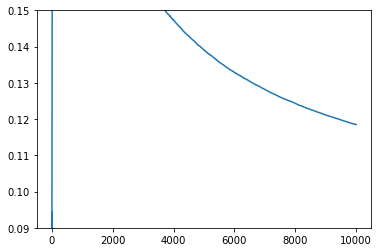

In [31]:
pd.DataFrame(gym_info.agent.optim.loss).mean(1).expanding().mean().plot(
    ylim=(0.09, 0.15)
)

<AxesSubplot:>

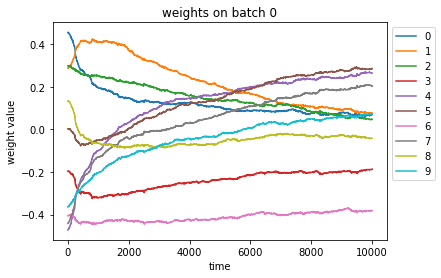

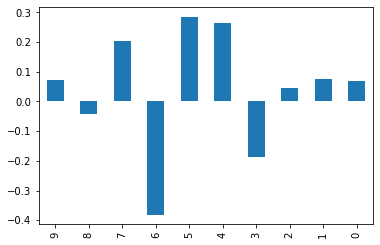

In [32]:
i_batch = 0
w = gym_info.agent.optim.updated_params["snarimax/~/linear"]["w"][:, i_batch, :, 0]
w = pd.DataFrame(w)

ax = w.plot(title=f"weights on batch {i_batch}")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight value")


plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

<AxesSubplot:>

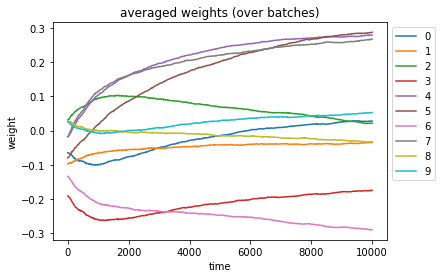

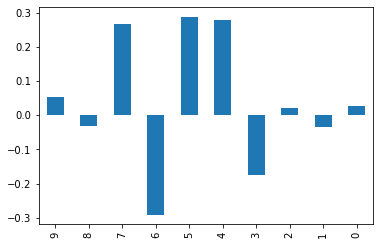

In [33]:
w = gym_info.agent.optim.updated_params["snarimax/~/linear"]["w"].mean(axis=1)[:, :, 0]
w = pd.DataFrame(w)
ax = w.plot(title="averaged weights (over batches)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight")

plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

# Taking mean inside simulation

In [34]:
%%time
def batched_gym_loop(eps):
    res = VMap(gym_loop)(eps)
    res = jax.tree_map(lambda x: x.mean(axis=0), res)
    return res


sim = unroll_transform_with_state(batched_gym_loop)

rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10000, 20)) * 0.3

params, state = sim.init(rng, eps)
(gym_output, gym_info), final_state = sim.apply(params, state, rng, eps)

CPU times: user 1.33 s, sys: 17.4 ms, total: 1.35 s
Wall time: 1.35 s


<AxesSubplot:>

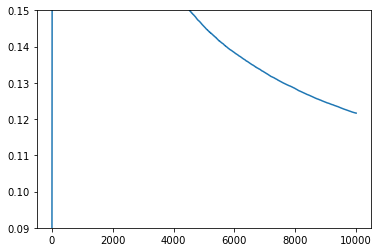

In [35]:
pd.Series(-gym_output.reward).expanding().mean().plot(ylim=(0.09, 0.15))

<AxesSubplot:>

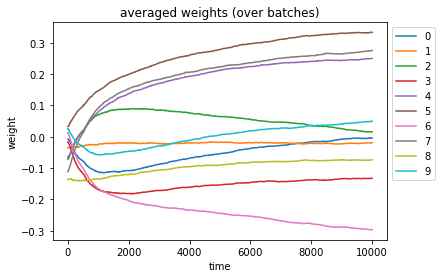

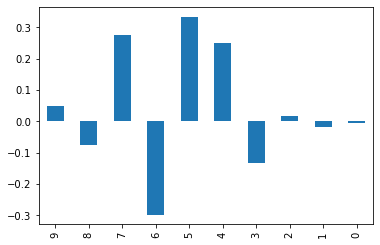

In [36]:
w = gym_info.agent.optim.updated_params["snarimax/~/linear"]["w"][:, :, 0]
w = pd.DataFrame(w)
ax = w.plot(title="averaged weights (over batches)")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel("time")
ax.set_ylabel("weight")

plt.figure()
w.iloc[-1][::-1].plot(kind="bar")

# Hyper parameter tuning

## First order optimizers

We will consider different first order optimizers, namely:
- SGD
- ADAM
- ADAGRAD

For each of them, we will scan the "step_size" parameter $\eta$.

We will average results over batches of size 40.

We will consider trajectories of size 10.000.

Finally, we will pickup the best parameter based of the minimum averaged loss for the last 5000 time steps.

In [37]:
%%time

STEP_SIZE_idx = pd.Index(onp.logspace(-4, 1, 30), name="step_size")
STEP_SIZE = jax.device_put(STEP_SIZE_idx.values)
OPTIMIZERS = [optax.sgd, optax.adam, optax.adagrad]

res = {}
for optimizer in tqdm(OPTIMIZERS):

    def gym_loop_scan_hyper_param(eps):
        def batch_eps(eps):
            def scan_params(step_size):
                opt = optimizer(step_size)
                return GymFeedback(Agent(opt), Env())(eps)

            res = VMap(scan_params)(STEP_SIZE)
            return res

        return jax.tree_map(lambda x: x.mean(axis=0), VMap(batch_eps)(eps))

    sim = unroll_transform_with_state(gym_loop_scan_hyper_param)
    rng = jax.random.PRNGKey(42)
    eps = jax.random.normal(rng, (10000, 40)) * 0.3

    params, state = sim.init(rng, eps)
    _res, state = sim.apply(params, state, rng, eps)
    res[optimizer.__name__] = _res


  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 12 s, sys: 157 ms, total: 12.1 s
Wall time: 12 s


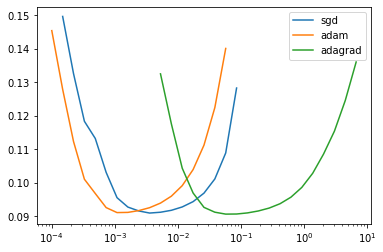

In [38]:
ax = None
BEST_STEP_SIZE = {}
BEST_GYM = {}
for name, (gym, info) in res.items():

    loss = pd.DataFrame(-gym.reward, columns=STEP_SIZE).iloc[-5000:].mean()

    BEST_STEP_SIZE[name] = loss.idxmin()
    best_idx = loss.reset_index(drop=True).idxmin()
    BEST_GYM[name] = jax.tree_map(lambda x: x[:, best_idx], gym)

    ax = loss[loss < 0.15].plot(logx=True, logy=False, ax=ax, label=name)
plt.legend()

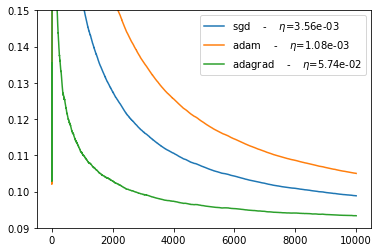

In [39]:
for name, gym in BEST_GYM.items():
    ax = (
        pd.Series(-gym.reward)
        .expanding()
        .mean()
        .plot(
            label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}", ylim=(0.09, 0.15)
        )
    )
ax.legend(bbox_to_anchor=(1.0, 1.0))

<AxesSubplot:>

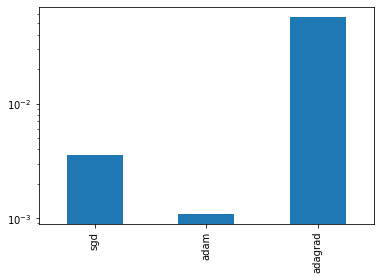

In [40]:
pd.Series(BEST_STEP_SIZE).plot(kind="bar", logy=True)

## Newton algorithm

Now let's consider the newton algorithm.

First let's test it with one set of parameter with average over 20 batches.

In [41]:
%%time
def gym_loop_scan_hyper_param(eps):
    def batch_eps(eps):
        opt = newton(0.05, eps=20.0)
        return GymFeedback(Agent(opt), Env())(eps)

    return jax.tree_map(lambda x: x.mean(axis=0), VMap(batch_eps)(eps))


sim = unroll_transform_with_state(gym_loop_scan_hyper_param)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10000, 20)) * 0.3

params, state = sim.init(rng, eps)
(gym, info), state = sim.apply(params, state, rng, eps)

CPU times: user 1.91 s, sys: 50.8 ms, total: 1.96 s
Wall time: 1.76 s


<AxesSubplot:>

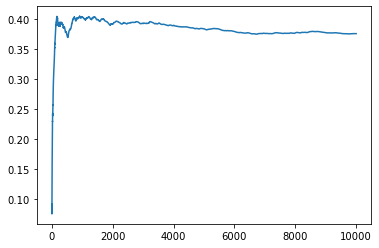

In [42]:
pd.Series(-gym.reward).expanding().mean().plot()

In [43]:
%%time

STEP_SIZE = pd.Index(onp.logspace(-2, 3, 10), name="step_size")
EPS = pd.Index(onp.logspace(-4, 3, 5), name="eps")

HPARAMS_idx = pd.MultiIndex.from_product([STEP_SIZE, EPS])
HPARAMS = jnp.stack(list(map(onp.array, HPARAMS_idx)))


def gym_loop_scan_hyper_param(eps):
    def batch_eps(eps):
        def scan_params(hparams):
            step_size, newton_eps = hparams
            opt = newton(step_size, eps=newton_eps)

            return GymFeedback(Agent(opt), Env())(eps)

        res = VMap(scan_params)(HPARAMS)
        return res

    return jax.tree_map(lambda x: x.mean(axis=0), VMap(batch_eps)(eps))


sim = unroll_transform_with_state(gym_loop_scan_hyper_param)
rng = jax.random.PRNGKey(42)
eps = jax.random.normal(rng, (10000, 40)) * 0.3

params, state = sim.init(rng, eps)
res_newton, state = sim.apply(params, state, rng, eps)

CPU times: user 16.2 s, sys: 343 ms, total: 16.6 s
Wall time: 15.7 s


In [44]:
gym_newton, info_newton = res_newton

In [45]:
loss_newton = pd.DataFrame(-gym_newton.reward, columns=HPARAMS_idx).mean().unstack()

In [46]:
loss_newton = (
    pd.DataFrame(-gym_newton.reward, columns=HPARAMS_idx).iloc[-5000:].mean().unstack()
)

Best newton parameters:  0.464158883361278 0.31622776601683794


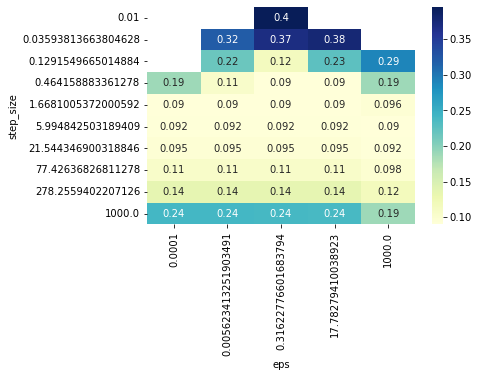

In [47]:
sns.heatmap(loss_newton[loss_newton < 0.4], annot=True, cmap="YlGnBu")

STEP_SIZE, NEWTON_EPS = loss_newton.stack().idxmin()

x = -gym_newton.reward[-5000:].mean(axis=0)
x = jax.ops.index_update(x, jnp.isnan(x), jnp.inf)
I_BEST_PARAM = jnp.argmin(x)


BEST_NEWTON_GYM = jax.tree_map(lambda x: x[:, I_BEST_PARAM], gym_newton)
print("Best newton parameters: ", STEP_SIZE, NEWTON_EPS)

Text(0.5, 1.0, 'Rolling mean of loss (5000) time-steps')

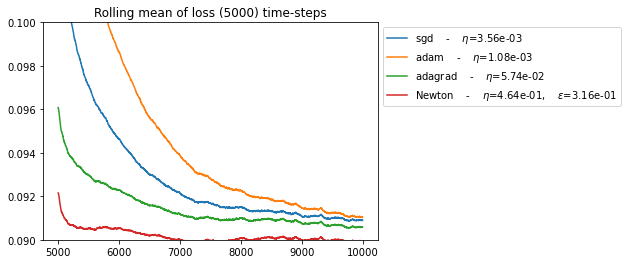

In [48]:
for name, gym in BEST_GYM.items():
    pd.Series(-gym.reward).rolling(5000, min_periods=5000).mean().plot(
        label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}", ylim=(0.09, 0.1)
    )

gym = BEST_NEWTON_GYM
ax = (
    pd.Series(-gym.reward)
    .rolling(5000, min_periods=5000)
    .mean()
    .plot(
        label=f"Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}"
    )
)
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.title("Rolling mean of loss (5000) time-steps")

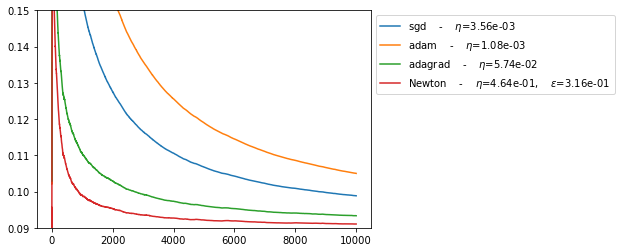

In [49]:
for name, gym in BEST_GYM.items():
    pd.Series(-gym.reward).expanding().mean().plot(
        label=f"{name}    -    $\eta$={BEST_STEP_SIZE[name]:.2e}", ylim=(0.09, 0.15)
    )
gym = BEST_NEWTON_GYM
ax = (
    pd.Series(-gym.reward)
    .expanding()
    .mean()
    .plot(
        label=f"Newton    -    $\eta$={STEP_SIZE:.2e},    $\epsilon$={NEWTON_EPS:.2e}"
    )
)
ax.legend(bbox_to_anchor=(1.0, 1.0))

In agreement with Hazan's paper, we see that Newton's algorithm performs much better than sgd.

In addition, we note that
- adam does not perform well in this online setting.
- adagrad performormance is between newton and sgd.